In [1]:
#Libraries
import re
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import keras
from keras.models import load_model
from keras.layers import *
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras import backend as K
from keras import layers


import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1" 

In [2]:
def processed_data(data):
    data=data.drop(columns=["Unnamed: 0"])
    data['Utterances'] = data['Utterances'].apply(lambda x: x.lower())
    data['Utterances'] = data['Utterances'].apply(lambda x: re.sub('[^a-zA-z0-9\s]','',x))

    y = pd.get_dummies(data['Basic']).values

    return data,y

In [3]:
def DA_label_count(data):
    label_count=data.groupby('Basic')['Basic'].agg('count')
    label_count.to_numpy(dtype=int)
    label_count = np.expand_dims(label_count, axis=0)
    label_count.shape=(5,1)
    labels=np.array(['B', 'D', 'F', 'Q', 'S'])
    labels.shape=(5,1)
    label_count=np.column_stack((labels,label_count))
    df = pd.DataFrame(label_count, columns=['Label', 'Count'])
    convert_dict = {
                    'Label': str,
                    'Count': int
                   }  
    df = df.astype(convert_dict)
    return df

In [4]:
full_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\full_set.csv')
MAX_PADDING = 100
def x_value(data):
    tokenizer = Tokenizer(num_words = 5000, split=" ")
    tokenizer.fit_on_texts(full_data['Utterances'].values)
    x = tokenizer.texts_to_sequences(data['Utterances'].values)
    x = pad_sequences(x, padding='post', maxlen=MAX_PADDING)
    
    return x

In [5]:
train_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\train.csv')
train_data,y_train = processed_data(train_data)
x_train = x_value(train_data)

val_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\val.csv')
val_data,y_val = processed_data(val_data)
x_val = x_value(val_data)

test_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\test.csv')
test_data,y_test = processed_data(test_data)
x_test = x_value(test_data)

In [6]:
MAX_LENGTH_PER_SENTENCE=100
units = 128
drop = 0.2
encoder_input = keras.Input(shape=(MAX_LENGTH_PER_SENTENCE))

def module(encoder_input):
    x =layers.Embedding(input_dim=5000, 
                        output_dim=256, 
                        input_length=x_train.shape[1])(encoder_input)
                                
    activations = Bidirectional(LSTM(units, 
                                    dropout=0.3, 
                                    recurrent_dropout=0.2,
                                    return_sequences=True))(x)

    attention = Dense(1, activation='tanh')(activations)
    attention = Flatten()(attention)
    attention = Activation('softmax')(attention)
    attention = RepeatVector(units*2)(attention)
    attention = Permute((2, 1))(attention)

    sent_representation = Multiply()([activations, attention])
    sent_representation = Lambda(lambda xin: K.sum(xin, axis=-2), 
                                output_shape=(units*2,))(sent_representation)

    
    reshape = Reshape((-1, 1, 256))(sent_representation)
    flat = TimeDistributed(Flatten())(reshape)
    dense_1 = Dense(5, activation='relu')(flat)
    dropout_1 = Dropout(drop)(dense_1)


    #conversation level
    biLSTM1 = Bidirectional(LSTM(units = 256,
                                 input_shape = (2, 256),
                                 return_sequences='true'))(dropout_1)
    biLSTM2 = Bidirectional(LSTM(5))(biLSTM1)

    dense_2 = Dense(5, activation='relu')(biLSTM2)
    dropout_2 = Dropout(drop)(dense_2)

    # concatenate 2 final layers
    # flatten the output of the attention(word level) + dense + dropout so that it can be concatenated with the output of BiLSTM
    dropout_flat = Flatten()(dropout_1)
    # concatenating the output of attention(word level) + dense + dropout with the output of BiLSTM + dense + dropout
    merged_2 = concatenate([dropout_flat, dropout_2])
    # adding a dense layer
    dense_3 = Dense(units=5, input_shape=(1,))(merged_2)
    # adding softmax for multiclass classification
    output = Activation('softmax')(dense_3)

    return output

In [7]:
model = keras.Model(inputs=[encoder_input], outputs=[module(encoder_input)])
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 100, 256)     1280000     input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 100, 256)     394240      embedding[0][0]                  
__________________________________________________________________________________________________
dense (Dense)                   (None, 100, 1)       257         bidirectional[0][0]              
______________________________________________________________________________________________

In [8]:
early_stopping = keras.callbacks.EarlyStopping(monitor='accuracy', 
                                               mode='auto', 
                                               patience=1, 
                                               verbose=1)

In [9]:
model.fit(x_train, y_train, 
          epochs=100, 
          batch_size=32, 
          verbose=1,
          callbacks=[early_stopping],
          validation_data=(x_val, y_val))

Epoch 1/100
2346/2346 [==============================] - 1226s 519ms/step - loss: 0.8763 - accuracy: 0.6853 - val_loss: 0.7371 - val_accuracy: 0.7295
Epoch 2/100
2346/2346 [==============================] - 1255s 535ms/step - loss: 0.6919 - accuracy: 0.7497 - val_loss: 0.6775 - val_accuracy: 0.7568
Epoch 3/100
2346/2346 [==============================] - 1248s 532ms/step - loss: 0.6397 - accuracy: 0.7687 - val_loss: 0.6592 - val_accuracy: 0.7634
Epoch 4/100
2346/2346 [==============================] - 1244s 530ms/step - loss: 0.6128 - accuracy: 0.7772 - val_loss: 0.6715 - val_accuracy: 0.7554
Epoch 5/100
2346/2346 [==============================] - 1310s 558ms/step - loss: 0.5894 - accuracy: 0.7839 - val_loss: 0.6639 - val_accuracy: 0.7639
Epoch 6/100
2346/2346 [==============================] - 1296s 553ms/step - loss: 0.5708 - accuracy: 0.7900 - val_loss: 0.6673 - val_accuracy: 0.7646
Epoch 7/100
2346/2346 [==============================] - 1343s 573ms/step - loss: 0.5552 - accuracy:

In [10]:
model.save('SAVED_MODEL.h5')

C:\Users\user1\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [11]:
saved_model = load_model('SAVED_MODEL.h5')

In [12]:
saved_model.evaluate(x_test,y_test)

522/522 [==============================] - 89s 168ms/step - loss: 0.7228 - accuracy: 0.7631ETA: 0s - loss: 0.7228 - accuracy: 0.


[0.7227932214736938, 0.7631279826164246]

In [13]:
y_pred = saved_model.predict(x_test)

In [14]:
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)


from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix\n')
print(confusion)

Confusion Matrix

[[1708    3   19    0  422]
 [  63 1241  137   97  801]
 [ 155   88 1054    0  111]
 [  38   55    0  496  642]
 [ 608  442   21  254 8246]]


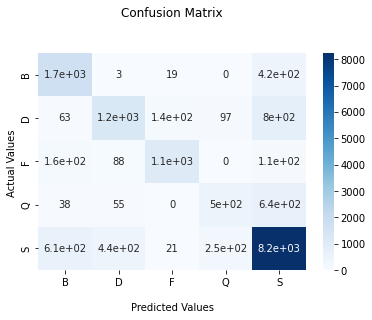

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sns.heatmap(confusion, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['B','D','F','Q','S'])
ax.yaxis.set_ticklabels(['B','D','F','Q','S'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [16]:
from sklearn.metrics import f1_score
print("F1 score(macro)",f1_score(y_test, y_pred, average='macro'))
print("F1 score(micro)",f1_score(y_test, y_pred, average='micro'))

F1 score(macro) 0.6855997662874336
F1 score(micro) 0.7631279564097958


In [17]:
DA = np.array(['B','D','F','Q','S'])
a = ["will you go"]
tokenizer = Tokenizer(num_words = 5000, split=" ")
full_data = pd.read_csv('C:\\Users\\user1\\Documents\\repo\\dialog act RNN\\MRDA\\full_set.csv')
tokenizer.fit_on_texts(full_data['Utterances'].values)
a = tokenizer.texts_to_sequences(a)
a = np.array(a)
a = pad_sequences(a, padding='post', maxlen=MAX_LENGTH_PER_SENTENCE)
prediction = saved_model.predict(np.array(a))
print(DA[prediction.argmax(1)])

['Q']
